# dataset.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os

# os.chdir("./../data/")
my_path_ground = '/data2/spike_sorting/quiroga/'

'''
filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

'''
filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy1_noise025.mat", "C_Easy1_noise03.mat", "C_Easy1_noise035.mat", "C_Easy1_noise04.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

dataset_num = 20
training_num = 2400
spike_length = 50

training_spike_group = np.zeros((dataset_num, training_num, spike_length))

for ds in range(20):
    mat1 = io.loadmat(my_path_ground + filename[ds])
    raw = mat1['data'][0]
    ans_times = mat1['spike_times'][0][0][0]
    ans_cluster = mat1['spike_class'][0][0][0]

    slope = np.zeros(len(raw)-2)
    for i in range(len(raw)-2):
        slope[i] = raw[i+1] - raw[i]

    spike_group = np.zeros((len(ans_times), spike_length))

    for i in range(len(ans_times)):
        max_slope_index = ans_times[i] + np.argmax(slope[ans_times[i] : ans_times[i] + 25])
        spike_group[i, :] = raw[max_slope_index - 10 : max_slope_index + 40]

    # #max_slope_idx_check###########################################
    # max_slope_index = np.zeros(len(ans_times))
    
    # for i in range(len(ans_times)):
    #     slope_value = np.zeros(49)
    #     for j in range(49):
    #         slope_value[j] = abs(spike_group[i, j+1] - spike_group[i, j])
    #     max_slope_index[i] = np.argmax(slope_value)
    # print(max_slope_index)

    # x = np.arange(0, 50, 1)
    # plt.figure()
    # plt.title(f'max_slope_index: {max_slope_index[0]}')
    # plt.plot(x, spike_group[0, :])

    # # 세로축 격자 추가
    # for v in x:  # x축의 모든 값에 대해 세로선을 그림
    #     plt.axvline(x=v, color='gray', linestyle='--', linewidth=0.5)

    ######################################################

    training_spike_group[ds, :, :] = spike_group[:training_num, :]

training_spike_group_reshape = training_spike_group.reshape(-1, spike_length)

np.random.shuffle(training_spike_group_reshape)

# # check dataset
# x = np.arange(0, 50, 1)
# plt.figure()
# plt.plot(x, training_spike_group_reshape[1, :])
# print(np.shape(training_spike_group_reshape))


np.save(my_path_ground + 'training_dataset_20', training_spike_group_reshape)

# ssp_ITM_quant.py

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from scipy import io

# 데이터 파일이 위치한 경로 설정
my_path_ground = '/data2/spike_sorting/quiroga/'

# 데이터 파일 목록과 템플릿 파일 목록 설정
filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy1_noise025.mat", "C_Easy1_noise03.mat", "C_Easy1_noise035.mat", "C_Easy1_noise04.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

template =  ["Spike_TEMPLATE_e1n005.npy", "Spike_TEMPLATE_e1n010.npy", "Spike_TEMPLATE_e1n015.npy", "Spike_TEMPLATE_e1n020.npy",
             "Spike_TEMPLATE_e1n025.npy", "Spike_TEMPLATE_e1n030.npy", "Spike_TEMPLATE_e1n035.npy", "Spike_TEMPLATE_e1n040.npy",
             "Spike_TEMPLATE_e2n005.npy", "Spike_TEMPLATE_e2n010.npy", "Spike_TEMPLATE_e2n015.npy", "Spike_TEMPLATE_e2n020.npy",
             "Spike_TEMPLATE_d1n005.npy", "Spike_TEMPLATE_d1n010.npy", "Spike_TEMPLATE_d1n015.npy", "Spike_TEMPLATE_d1n020.npy",
             "Spike_TEMPLATE_d2n005.npy", "Spike_TEMPLATE_d2n010.npy", "Spike_TEMPLATE_d2n015.npy", "Spike_TEMPLATE_d2n020.npy"]

# 템플릿을 만드는 함수 정의
def making_naive_template():
    # 20개의 데이터셋에 대해 처리
    for ds in range(20):
        print("")
        print("data", ds)
        
        # 데이터 파일 불러오기
        mat1 = io.loadmat(my_path_ground + filename[ds])
        raw = mat1['data'][0]
        thr = 0.9  # 스파이크 탐지 임계값 설정 
        
        wait = 0  # 스파이크 탐지 대기 시간
        spike_index = 0  # 스파이크 인덱스 초기화
        spike = np.zeros((10000, 50))  # 스파이크 데이터를 저장할 배열
        spike_times = np.zeros(10000)  # 스파이크 시간 기록
        training_cycle = 100  # 훈련 사이클 횟수 # 초기 100개만 써서 템플릿 만든다했잖아
        slope = np.zeros(len(raw)-2)  # 기울기 배열 초기화
        
        # raw 데이터의 기울기 계산
        for i in range(len(raw)-2):
            slope[i] = raw[i+1] - raw[i]
        
        # 스파이크 탐지
        for i in range(len(raw)-2):
            wait += 1
            if(21 <= wait):
                if(raw[i+1] < raw[i+2] and raw[i+1] <= raw[i] and raw[i+1] < -thr) or (raw[i+1] > raw[i+2] and raw[i] <= raw[i+1] and raw[i+1] > thr):
                    # 기울기가 최대인 지점에서 스파이크 추출
                    max_slope_index = i + np.argmax(slope[i - 8 : i + 5]) - 8
                    spike[spike_index, :] = raw[max_slope_index - 10 : max_slope_index + 40]  # 스파이크 파형 추출
                    spike_times[spike_index] = i - 20  # 스파이크 시간 기록
                    spike_index += 1        
                    wait = 0  # 대기 시간 초기화
        
        num_cluster = 3  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
        Cluster = np.zeros((num_cluster, 50))  # 클러스터 배열 초기화
        distance_size = 0  # 거리 계산을 위한 배열 크기
        cluster_num = np.zeros(num_cluster)  # 각 클러스터의 데이터 수 초기화
        
        for i in range(num_cluster):
            distance_size += i + 1  # 거리 계산 배열 크기 계산
        distance = np.zeros(distance_size)  # 거리 배열 초기화
        
        # 훈련 사이클 시작
        for spike_index in range(training_cycle):
            spike_n = spike[spike_index, :]  # 현재 스파이크
            
            if(spike_index == 0):
                Cluster[0, :] = spike_n  # 첫 번째 스파이크는 첫 번째 클러스터에 배정
                Cl_num = 1  # 클러스터 수
                cluster_num[0] += 1  # 클러스터 데이터 수 증가
            else:
                # 각 클러스터와의 거리 계산
                for i in range(num_cluster): # 0, 1, 2 까지는 기존 클러스터와 지금 스파이크와의 거리
                    distance[i] = np.sum(abs(Cluster[i, 5:25] - spike_n[5:25])) * 17 + np.sum(abs(Cluster[i, 0:5] - spike_n[0:5])) * 2 + np.sum(abs(Cluster[i, 25:50] - spike_n[25:50])) * 2
                
                k = 0
                for j in range(1, num_cluster):
                    k = k + j
                    for i in range(j, num_cluster):
                        # 훈련 초기 단계에서는 임계값을 1.5로 설정
                        if(spike_index < 30):
                            mer_thr = 1.5
                        else:
                            mer_thr = 2.5
                        
                        # 클러스터의 데이터 수가 10 이상인 경우 거리를 크게 설정
                        if(cluster_num[j-1] > 10) or (cluster_num[i] > 10):
                            distance[i + j * num_cluster - k] = 1500000000000
                        else:
                            # 두 클러스터 간의 거리 계산
                            distance[i + j * num_cluster - k] = np.sum(abs(Cluster[j - 1, 5:25] - Cluster[i, 5:25])) * 17 + np.sum(abs(Cluster[j - 1, 0:5] - Cluster[i, 0:5])) * 2 + np.sum(abs(Cluster[j - 1, 25:50] - Cluster[i, 25:50])) * 2
                            distance[i + j * num_cluster - k] = distance[i + j * num_cluster - k] * mer_thr
                
                # 가장 작은 거리를 가진 클러스터를 찾고 업데이트
                m = np.argmin(distance)
                if(m < num_cluster): #클러스터와 현재 스파이크간 거리에서 젤 작은 게 있을 때
                    Cluster[m, :] = (Cluster[m, :] * 15 + spike_n) / 16  # 클러스터 업데이트
                    cluster_num[m] += 1  # 클러스터 데이터 수 증가
                else:  #클러스터와 클러스터 간 거리에서 젤 작은 게 있을 때
                    x = num_cluster
                    for i in range(1, num_cluster):
                        y = x + num_cluster - i
                        if(x <= m and m < y):
                            # 새로운 클러스터와 기존 클러스터를 결합
                            Cluster[i - 1, :] = (Cluster[i - 1, :] + Cluster[m - x + i, :]) / 2
                            cluster_num[i - 1] = cluster_num[i - 1] + cluster_num[m - x + i]
                            Cluster[m - x + i, :] = spike_n  # 새로운 스파이크 할당
                            cluster_num[m - x + i] = 1  # 새로운 클러스터 데이터 수 1로 초기화
                        x = y
        
        # 클러스터 템플릿을 파일로 저장
        np.save(my_path_ground + template[ds], Cluster)
        
# 템플릿 생성 함수 호출
making_naive_template()



data 0

data 1

data 2

data 3

data 4

data 5

data 6

data 7

data 8

data 9

data 10

data 11

data 12

data 13

data 14

data 15

data 16

data 17

data 18

data 19



data 0


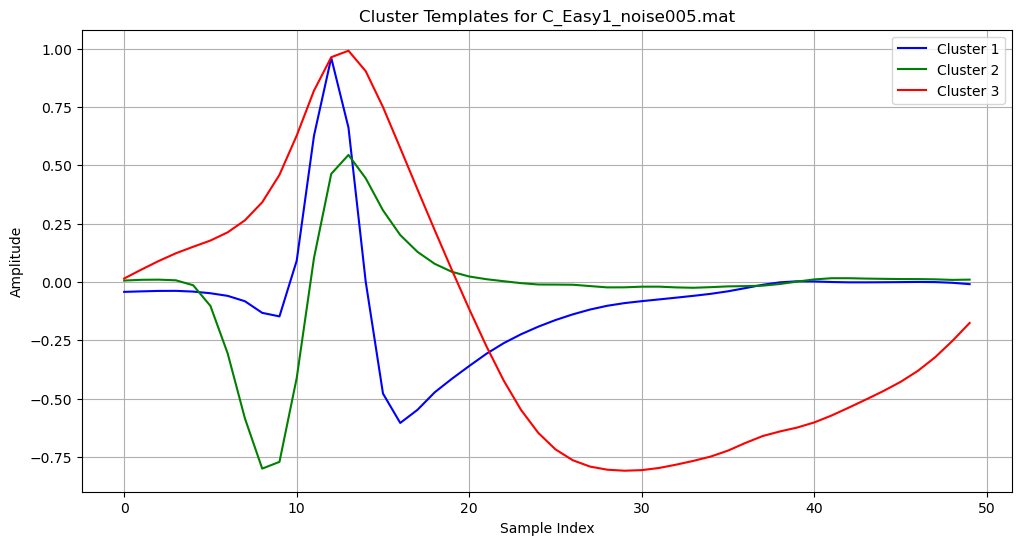


data 1


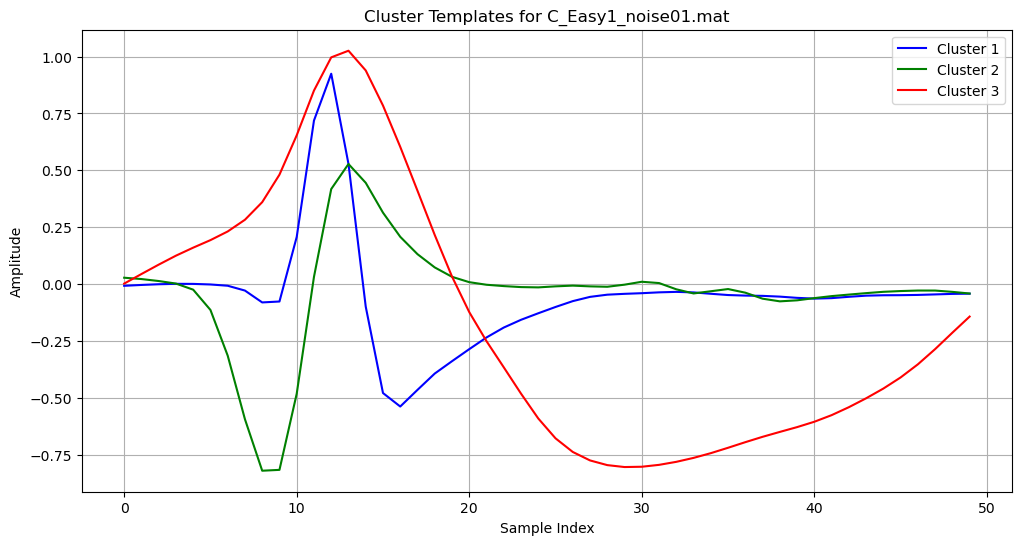


data 2


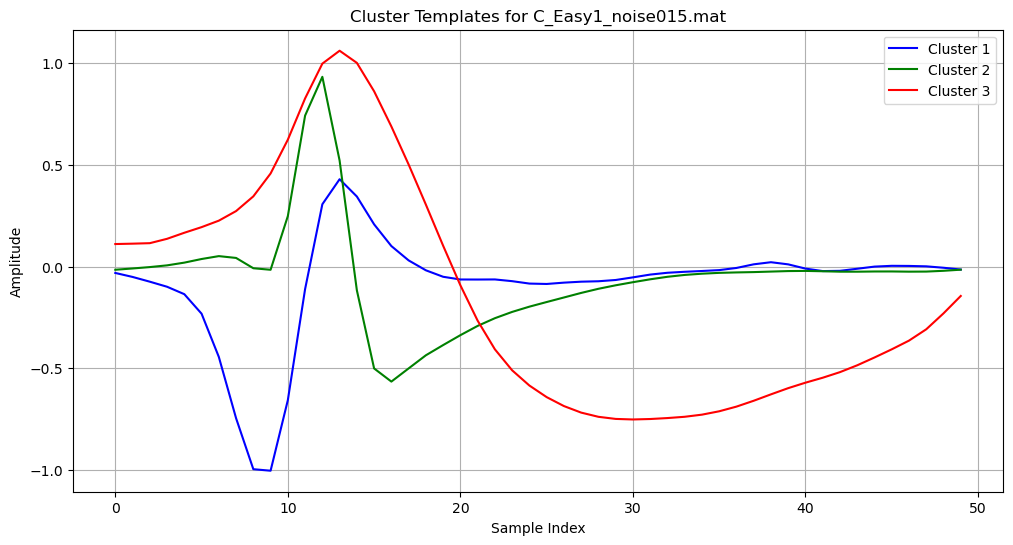


data 3


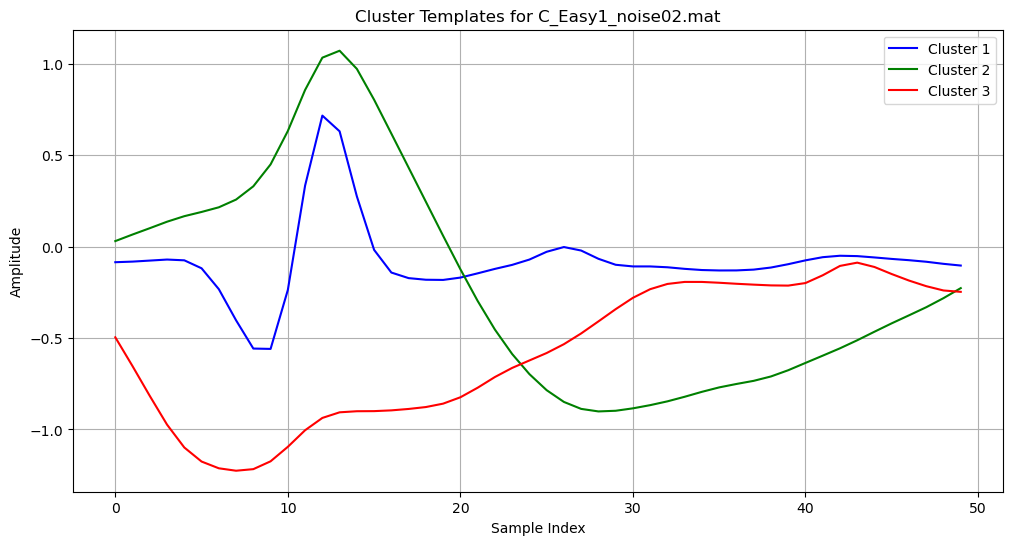


data 4


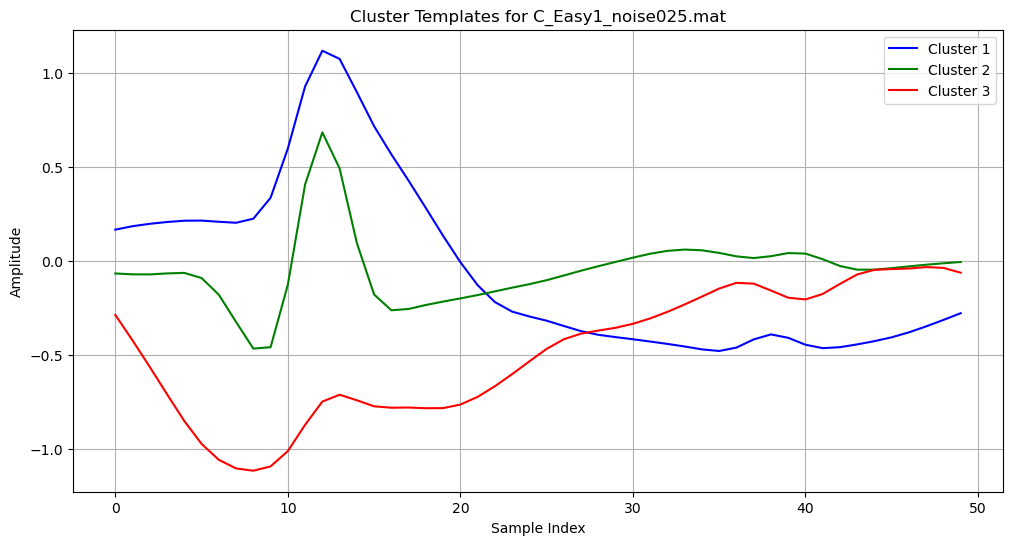


data 5


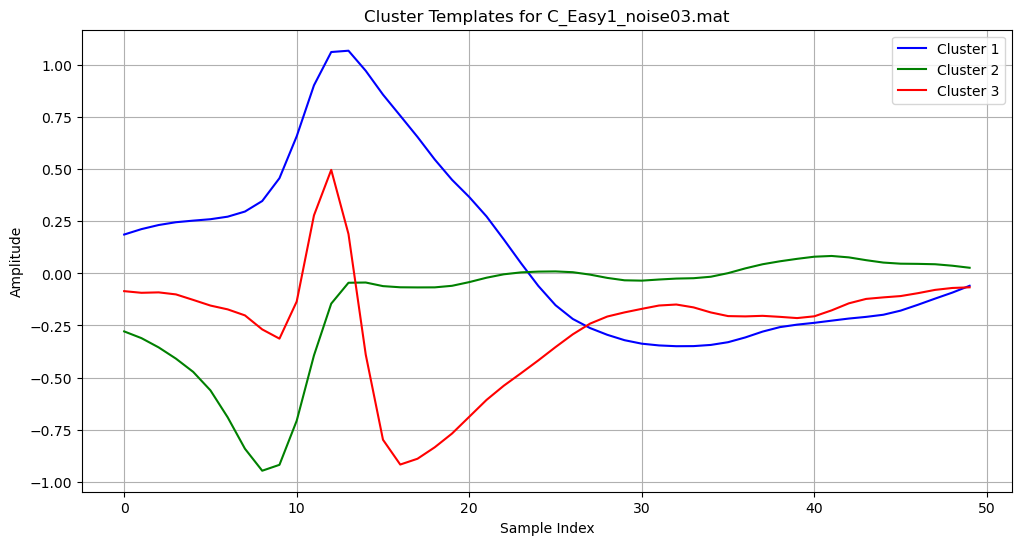


data 6


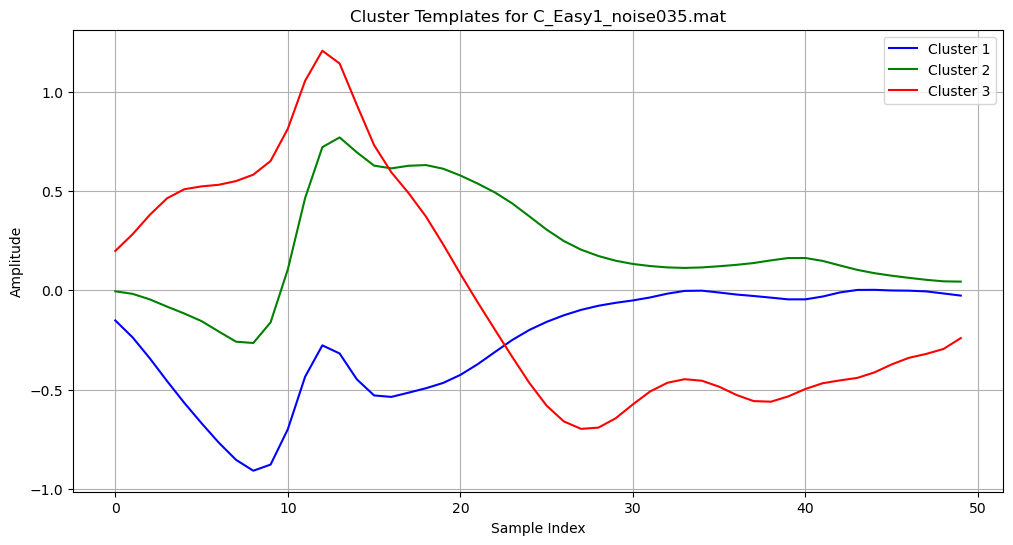


data 7


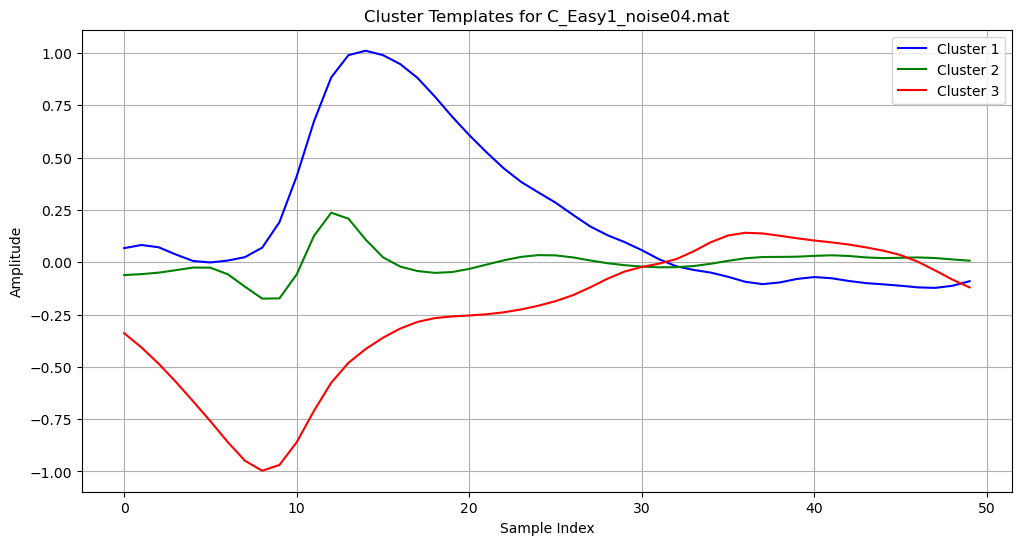


data 8


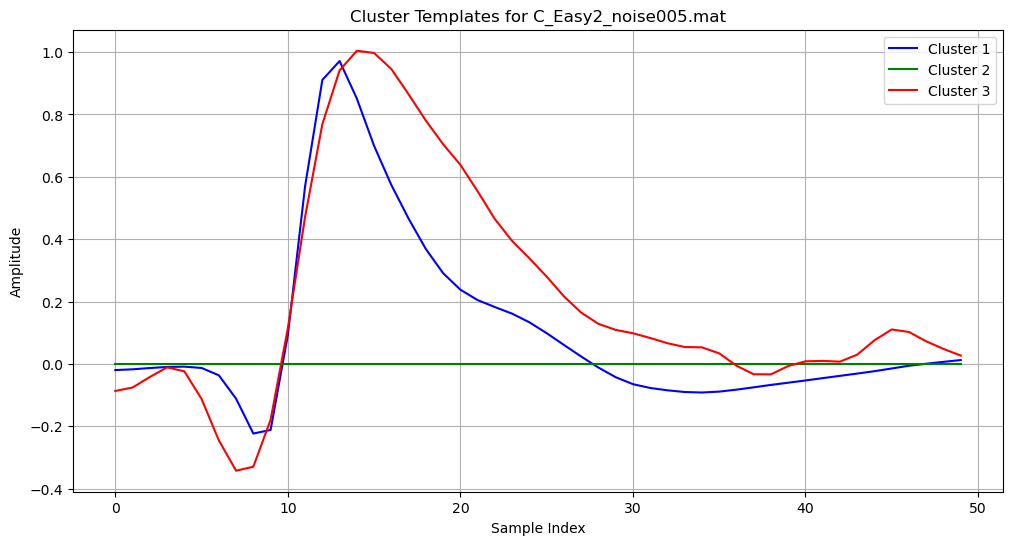


data 9


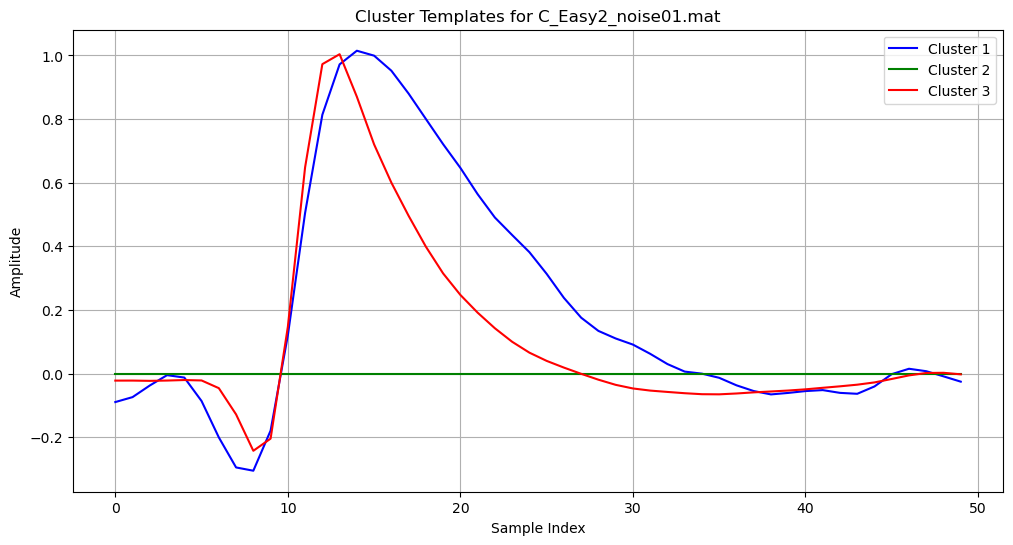


data 10


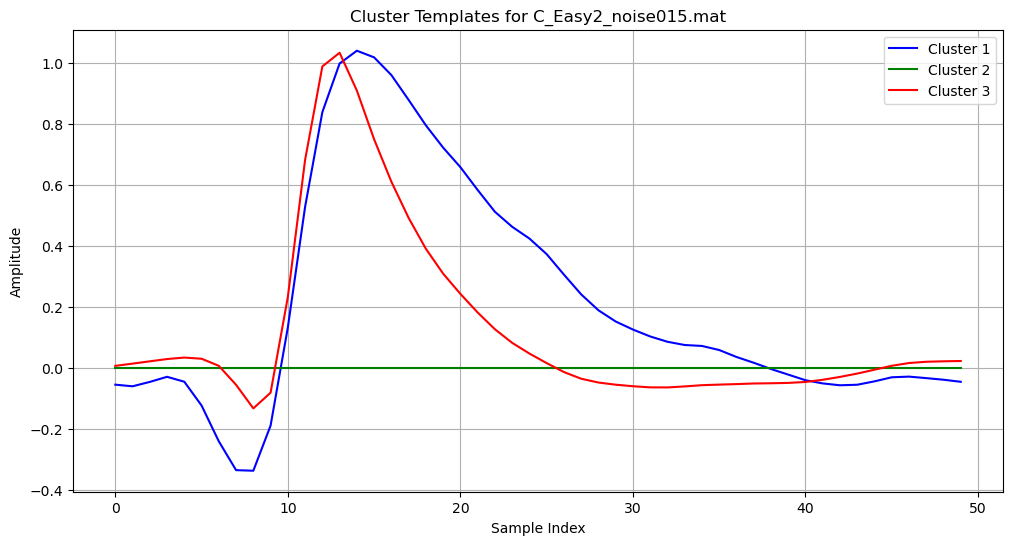


data 11


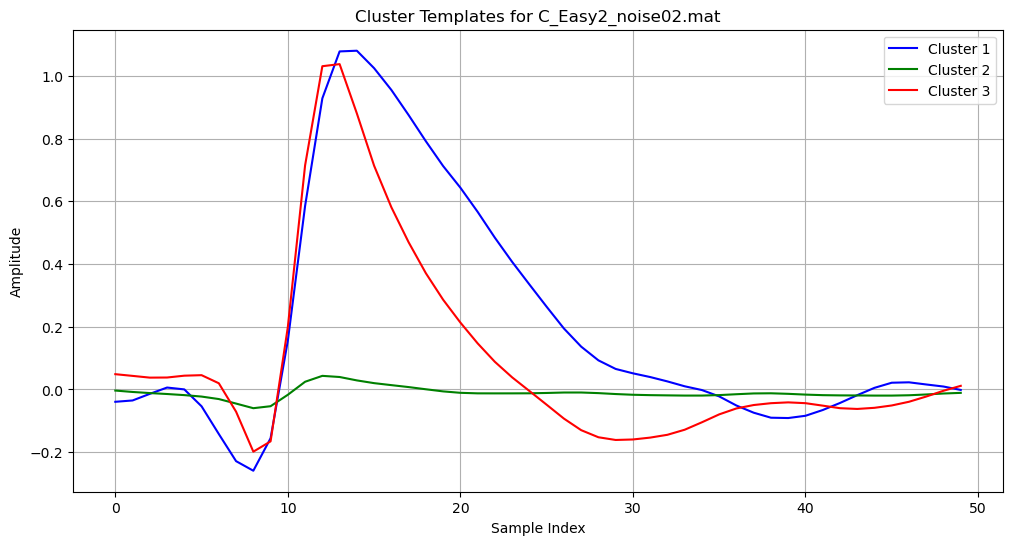


data 12


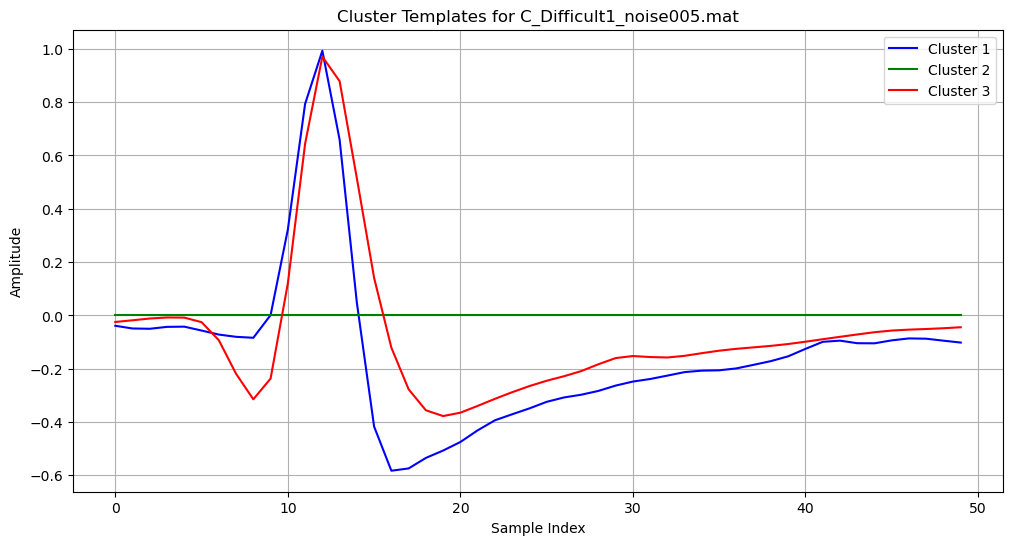


data 13


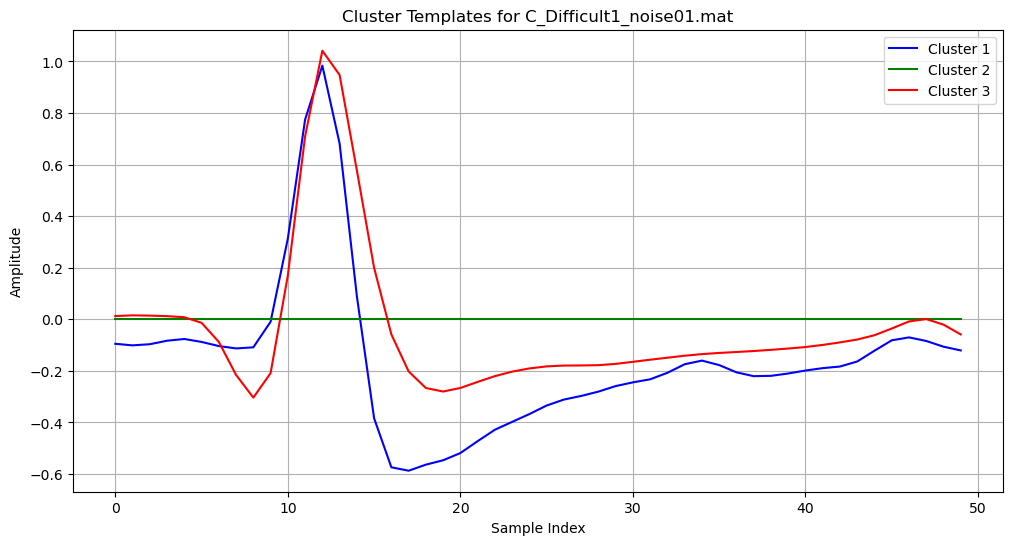


data 14


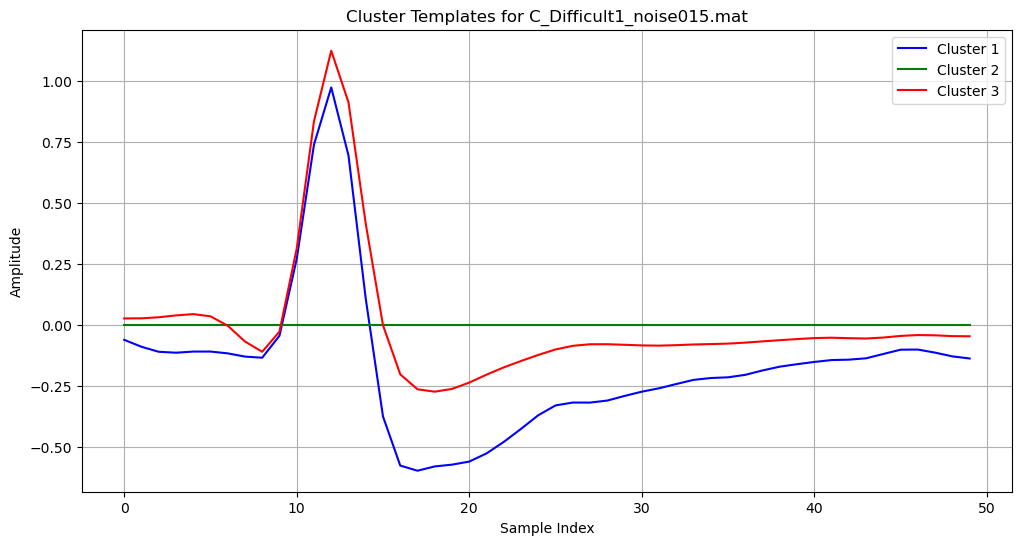


data 15


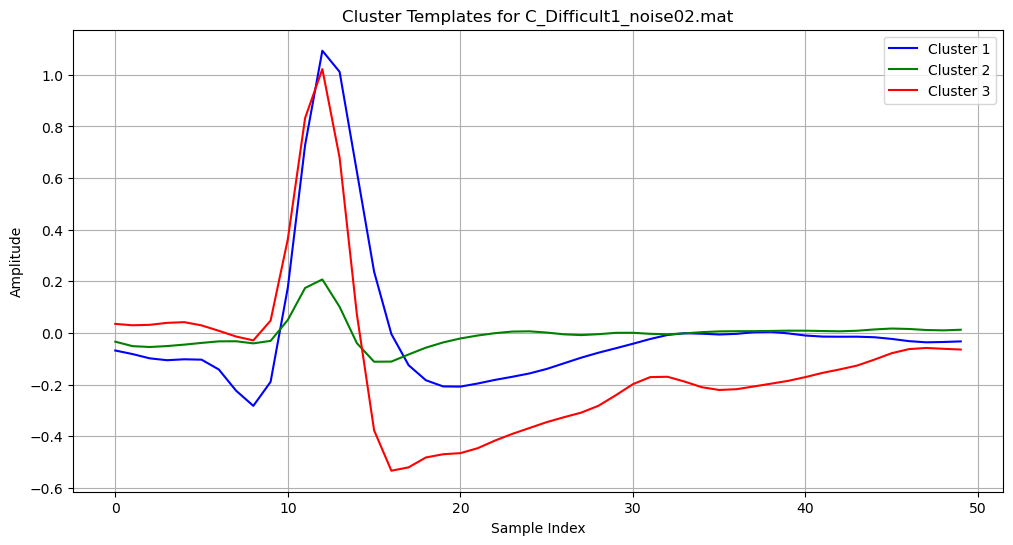


data 16


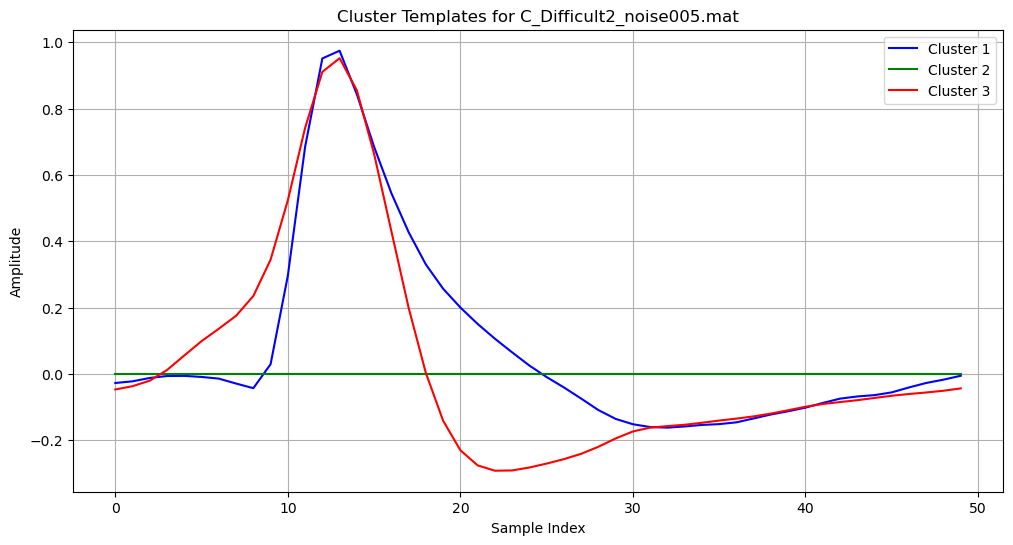


data 17


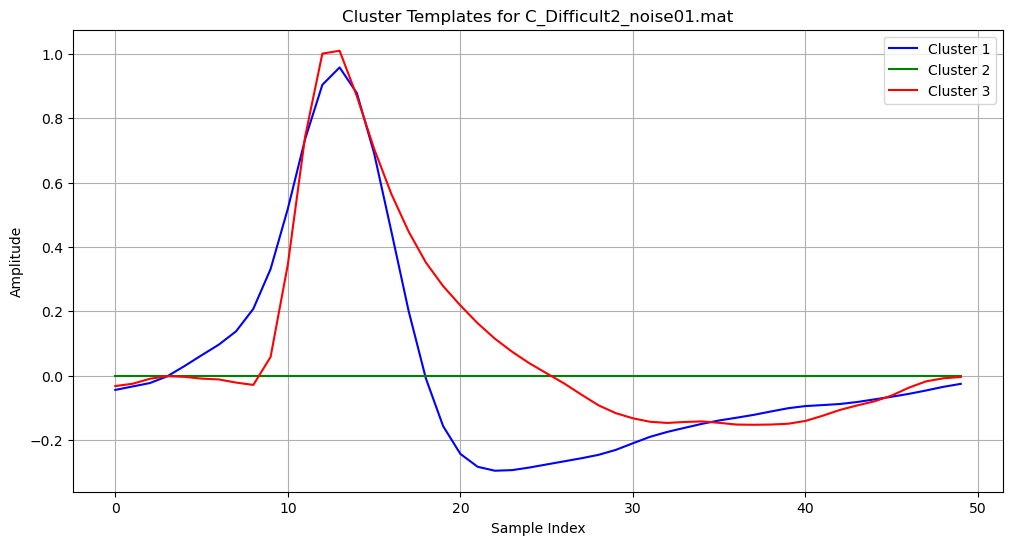


data 18


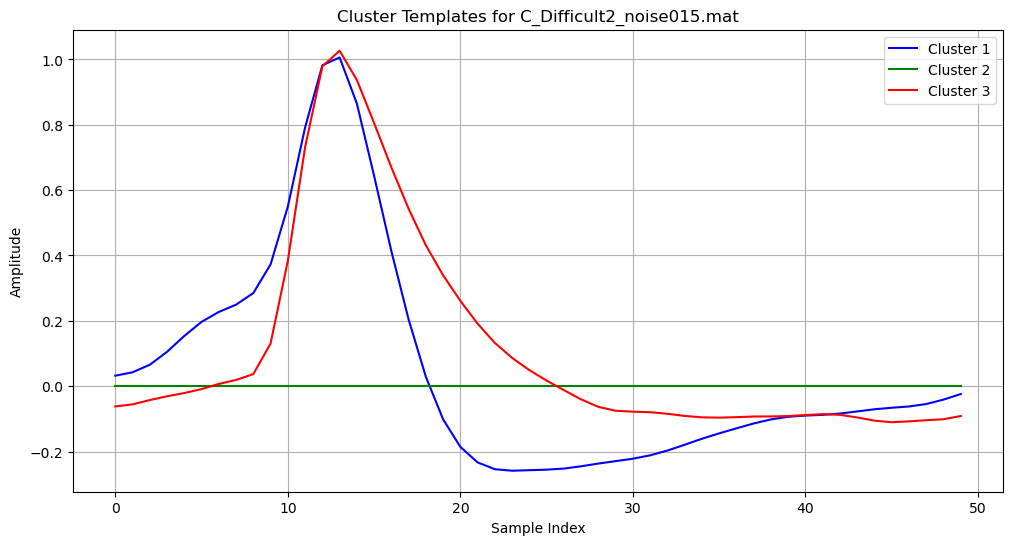


data 19


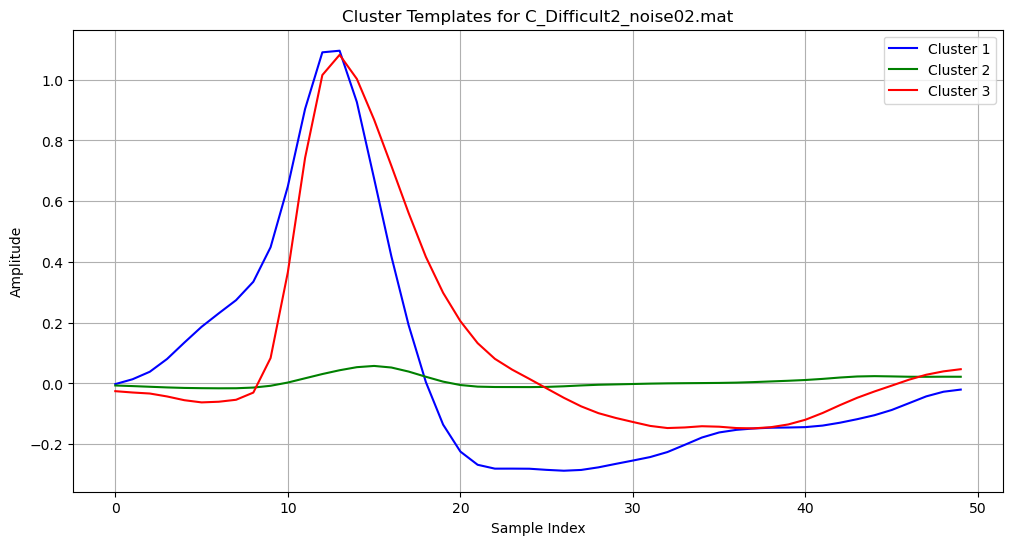

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# os.chdir('./../data')
my_path_ground = '/data2/spike_sorting/quiroga/'

from scipy import io

filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy1_noise025.mat", "C_Easy1_noise03.mat", "C_Easy1_noise035.mat", "C_Easy1_noise04.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

template =  ["Spike_TEMPLATE_e1n005.npy", "Spike_TEMPLATE_e1n010.npy", "Spike_TEMPLATE_e1n015.npy", "Spike_TEMPLATE_e1n020.npy",
             "Spike_TEMPLATE_e1n025.npy", "Spike_TEMPLATE_e1n030.npy", "Spike_TEMPLATE_e1n035.npy", "Spike_TEMPLATE_e1n040.npy",
             "Spike_TEMPLATE_e2n005.npy", "Spike_TEMPLATE_e2n010.npy", "Spike_TEMPLATE_e2n015.npy", "Spike_TEMPLATE_e2n020.npy",
             "Spike_TEMPLATE_d1n005.npy", "Spike_TEMPLATE_d1n010.npy", "Spike_TEMPLATE_d1n015.npy", "Spike_TEMPLATE_d1n020.npy",
             "Spike_TEMPLATE_d2n005.npy", "Spike_TEMPLATE_d2n010.npy", "Spike_TEMPLATE_d2n015.npy", "Spike_TEMPLATE_d2n020.npy"]


def making_naive_template():
    for ds in range(20):
        print("")
        print("data", ds)
        mat1 = io.loadmat(my_path_ground + filename[ds])
        raw = mat1['data'][0]
        thr = 0.9
        
        wait = 0
        spike_index = 0
        spike = np.zeros((10000, 50))
        spike_times = np.zeros(10000)
        training_cycle = 100
        slope = np.zeros(len(raw)-2)
        for i in range(len(raw)-2):
            slope[i]=raw[i+1]-raw[i]
            
        for i in range(len(raw)-2):
            wait += 1
            if(21 <= wait):
                if(raw[i+1] < raw[i+2] and raw[i+1] <= raw[i] and raw[i+1] < -thr) or (raw[i+1] > raw[i+2] and raw[i] <= raw[i+1] and raw[i+1] > thr):
                    
                    max_slope_index = i + np.argmax(slope[i - 8 : i + 5]) - 8
                    spike[spike_index, :] = raw[max_slope_index - 10 : max_slope_index + 40]
                    spike_times[spike_index] = i-20
                    spike_index += 1        
                    wait = 0
        
        num_cluster = 3
        Cluster = np.zeros((num_cluster, 50))
        distance_size = 0
        cluster_num = np.zeros(num_cluster)
        
        for i in range(num_cluster):
            distance_size += i+1    
        distance = np.zeros(distance_size)
        
        for spike_index in range(training_cycle):
            spike_n = spike[spike_index, :]
            
            if(spike_index == 0):
                Cluster[0, :] = spike_n
                cluster_num[0] += 1
                        
            else:
                for i in range(num_cluster):
                    distance[i] = np.sum(abs(Cluster[i, 5:25] - spike_n[5:25])) * 17 + np.sum(abs(Cluster[i, 0:5] - spike_n[0:5])) * 2 + np.sum(abs(Cluster[i, 25:50] - spike_n[25:50])) * 2
                #if(spike_index == 4):
                   # print(distance)
                k = 0
                for j in range(1, num_cluster):
                    k = k + j
                    for i in range(j, num_cluster):

                        if(spike_index < 30):
                            mer_thr = 1.5
                        else:
                            mer_thr = 2.5
                            
                        if(cluster_num[j-1]>10) or (cluster_num[i]>10):
                            distance[i + j * num_cluster - k] = 1500000000000
                        else:
                            distance[i + j * num_cluster - k] = np.sum(abs(Cluster[j - 1, 5:25] - Cluster[i, 5:25])) * 17 + np.sum(abs(Cluster[j - 1, 0:5] - Cluster[i, 0:5])) * 2 + np.sum(abs(Cluster[j - 1, 25:50] - Cluster[i, 25:50])) * 2
                            distance[i + j * num_cluster - k] = distance[i + j * num_cluster - k] * mer_thr
                            
                m = np.argmin(distance)
                if(m < num_cluster):
                    
                    Cluster[m, :] = (Cluster[m, :] * 15 + spike_n)/16
                    cluster_num[m] += 1
                    
                    
                else:
                    x = num_cluster
                    i
                    for i in range(1, num_cluster):
                        y = x + num_cluster - i
                        if(x <= m and m < y):
                            Cluster[i - 1, :] = (Cluster[i - 1, :] + Cluster[m - x + i, :])/2
                            cluster_num[i-1] = cluster_num[i-1] + cluster_num[m-x+i]
                            Cluster[m - x + i, :] = spike_n
                            cluster_num[m-x+i] = 1
                        x = y


        # Cluster plot
        plt.figure(figsize=(12, 6))
        colors = ['b', 'g', 'r']  # 클러스터별 색상 지정
        x_axis = np.arange(spike_length)  # x축 값 (스파이크 길이)

        for i in range(num_cluster):
            plt.plot(x_axis, Cluster[i, :], label=f'Cluster {i+1}', color=colors[i % len(colors)])

        plt.title(f'Cluster Templates for {filename[ds]}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        np.save(my_path_ground + template[ds], Cluster)
        
making_naive_template()

# ssp.train.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# os.chdir("./../data/")
my_path_ground = '/data2/spike_sorting/quiroga/'

filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
            "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
            "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
            "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]

template =  ["Spike_TEMPLATE_e1n005_new.npy", "Spike_TEMPLATE_e1n010_new.npy", "Spike_TEMPLATE_e1n015_new.npy", "Spike_TEMPLATE_e1n020_new.npy",
             "Spike_TEMPLATE_e2n005_new.npy", "Spike_TEMPLATE_e2n010_new.npy", "Spike_TEMPLATE_e2n015_new.npy", "Spike_TEMPLATE_e2n020_new.npy",
             "Spike_TEMPLATE_d1n005_new.npy", "Spike_TEMPLATE_d1n010_new.npy", "Spike_TEMPLATE_d1n015_new.npy", "Spike_TEMPLATE_d1n020_new.npy",
             "Spike_TEMPLATE_d2n005_new.npy", "Spike_TEMPLATE_d2n010_new.npy", "Spike_TEMPLATE_d2n015_new.npy", "Spike_TEMPLATE_d2n020_new.npy"]

spike_tot = ["Spike_e1n005.npy", "Spike_e1n010.npy", "Spike_e1n015.npy", "Spike_e1n020.npy",
            "Spike_e2n005.npy", "Spike_e2n010.npy", "Spike_e2n015.npy", "Spike_e2n020.npy",
            "Spike_d1n005.npy", "Spike_d1n010.npy", "Spike_d1n015.npy", "Spike_d1n020.npy",
            "Spike_d2n005.npy", "Spike_d2n010.npy", "Spike_d2n015.npy", "Spike_d2n020.npy"]

times_tot = ['Spike_e1n005_times.npy', 'Spike_e1n010_times.npy', 'Spike_e1n015_times.npy', 'Spike_e1n020_times.npy',
             'Spike_e2n005_times.npy', 'Spike_e2n010_times.npy', 'Spike_e2n015_times.npy', 'Spike_e2n020_times.npy',
             'Spike_d1n005_times.npy', 'Spike_d1n010_times.npy', 'Spike_d1n015_times.npy', 'Spike_d1n020_times.npy',
             'Spike_d2n005_times.npy', 'Spike_d2n010_times.npy', 'Spike_d2n015_times.npy', 'Spike_d2n020_times.npy']

thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])
#%%

from scipy import io

cluster_ans = np.zeros((16, 4000))

for i in range(16):
    mat1 = io.loadmat(filename[i])        
    cluster_ans[i, :len(mat1['spike_class'][0][0][0])] = mat1['spike_class'][0][0][0]


from torch.utils.data import DataLoader, Dataset

class spikedataset(Dataset):

    def __init__(self, path, transform = None):    
        
        self.transform = transform
        spike_h = np.load(path)
        self.spike = spike_h
        self.len = len(self.spike)
        
    def __getitem__(self, index):
        spike = self.spike[index]            
        if self.transform is not None:
            spike = self.transform(spike)
        return spike
    
    def __len__(self):
        return self.len

train_dataset = spikedataset(my_path_ground+'training_dataset_20.npy')
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
batch_size = 32
#%%

import torch 
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()

        # encoder
        self.conv1 = nn.Conv1d(1, 32, 3, stride = 2, bias = False) # 24
        self.conv2 = nn.Conv1d(32, 64, 3, stride = 2, bias = False) # 11
        self.conv3 = nn.Conv1d(64, 96, 3, stride = 2, bias = False) # 4 # 병현: 여기 5인데?
        self.fc1 = nn.Linear(96 * 5, 4, bias = False)
        
        # decoder
        self.fc4 = nn.Linear(4, 5 * 96, bias = False)
        self.deconv3 = nn.ConvTranspose1d(96, 64, 3, stride = 2, bias = False) #6 + 2 + 1= 9
        self.deconv1 = nn.ConvTranspose1d(64, 32, 3, stride = 2, output_padding=1, bias = False) #16(9-1)*stride + 4(kernel-1) + 1 = 21
        self.deconv2 = nn.ConvTranspose1d(32, 1, 3, stride = 2, output_padding=1, bias = False) #40 + 4 + 1 = 45
       

    def forward(self, x):

        # encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 96 * 5)
        mid = self.fc1(x)
        norm = torch.sqrt(torch.sum(torch.pow(mid, 2), dim = 1))
        h = (mid.t()/norm).t()

        # decoder
        z = F.relu(self.fc4(h))
        z = z.view(-1, 96, 5)
        z = F.relu(self.deconv3(z))
        z = F.relu(self.deconv1(z))
        z = self.deconv2(z)

        return h, z

net = AE()
#device = torch.device('cpu')

#net.load_state_dict(torch.load('allnobiasv2_7000.pth' , map_location = device))
#net.eval()
device_num = 0
net.cuda(device_num)
#%%
import torch.optim as optim
from scipy import io

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

training_cycle = 2400


num_cluster = 3
distance_size = 0
for i in range(num_cluster):
    distance_size += i+1
tau = np.zeros(3)


acc_y = np.zeros(50000)
acc_y2 = np.zeros(50000)
acc_y_test = np.zeros(50000)

acc_update = 0
#%%
max_epoch = 7000
for epoch in range(max_epoch):

    
    
    cluster_acc_data = np.zeros(16)
    cluster_acc_data2 = np.zeros(16)
    cluster_test = np.zeros(16)    
    
    
    
    if(epoch == 0 or epoch == 1 or epoch % 1000 == 999): 
    
        for ds in range(16):
            thr = thr_tot[ds]
            spike_template = np.load(template[ds])
            spike = np.load(spike_tot[ds])
            ans_cluster = cluster_ans[ds]
            times = np.load(times_tot[ds])
            print(ds+1)
            
            Cluster = np.zeros((num_cluster, 4))
            
            for i in range(num_cluster):
                spike_torch = torch.from_numpy(spike_template[i, :])
                spike_torch = spike_torch.view(1, 1, 50)
                inner_inf, spike_class = net(spike_torch.float().cuda(device_num))
                
                Cluster[i, :] = inner_inf.cpu().detach().numpy()
                
            b = np.zeros((len(spike), 4))
            
            
            for i in range(len(spike)):
                spike_torch = torch.from_numpy(spike[i, :])
                spike_torch = spike_torch.view(1, 1, 50)
                inner_inf, spike_class = net(spike_torch.float().cuda(device_num))
            
                b[i, :] = inner_inf.cpu().detach().numpy()
                
            spike_id = np.zeros(len(spike))
            distance = np.zeros(distance_size)
            tau = np.zeros(num_cluster)
            
            cos = cos_thr[ds]
            
            for spike_index in range(2400): # 원래 1400 아니냐?
                ft1, ft2, ft3, ft4 = b[spike_index, :]
                for q in range(num_cluster):
                    tau[q] = np.sum(b[spike_index, :] * Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                for i in range(num_cluster):
                    distance[i] = pow(abs(Cluster[i, 0] - ft1), 2) + pow(abs(Cluster[i, 1] - ft2), 2) + pow(abs(Cluster[i, 2] - ft3), 2) + pow(abs(Cluster[i, 3] - ft4), 2)
            
                if(np.max(tau)>=cos):
                    k = 0
                    for j in range(1, num_cluster):
                        k = k + j
                        for i in range(j, num_cluster):
                            distance[i + j * num_cluster - k] = np.sum(pow(Cluster[j-1, :] - Cluster[i, :], 2))*1500
                            # 1500이나 곱해준다. 걍 클러스터 간 병합은 이제 안하겠다는 뜻인 듯.
                            
                    m = np.argmin(distance)
                    if(m < num_cluster):
                        Cluster[m, 0] = (Cluster[m, 0] * 15 + ft1)/16
                        Cluster[m, 1] = (Cluster[m, 1] * 15 + ft2)/16
                        Cluster[m, 2] = (Cluster[m, 2] * 15 + ft3)/16
                        Cluster[m, 3] = (Cluster[m, 3] * 15 + ft4)/16
                        
                    else:
                        x = num_cluster
                                        
                        for i in range(1, num_cluster):
                            y = x + num_cluster - i
                            if(x <= m and m < y):
                                Cluster[i - 1, :] = (Cluster[i - 1, :] * 15 + Cluster[m - x + i, :])/16
                                Cluster[m - x + i, :] = (ft1, ft2, ft3, ft4)
                            x = y
                        assert False, '이게 맞나'
                            
            for spike_index in range(len(spike)):
                ft1, ft2, ft3, ft4 = b[spike_index, :]
                for q in range(num_cluster):
                    tau[q] = np.sum(b[spike_index, :] * Cluster[q, :])
                for i in range(num_cluster):
                    distance[i] = pow(abs(Cluster[i, 0] - ft1), 2) + pow(abs(Cluster[i, 1] - ft2), 2) + pow(abs(Cluster[i, 2] - ft3), 2) + pow(abs(Cluster[i, 3] - ft4), 2)
                
                if(np.max(tau)< -1):
                    spike_id[spike_index] = 4
                    assert False, '이게 맞나'
                    # 여기 들어올일은 없을 거 같은데
                else:
                    m = np.argmin(distance[0:num_cluster])
                    spike_id[spike_index] = m + 1
            
            cluster_accuracy = np.zeros(6)
            cluster_accuracy2 = np.zeros(6)
            cluster_accuracy3 = np.zeros(6)
            
            for ep in range(6):
                
                if(ep == 1 or ep == 4):
                    for i in range(len(spike)):
                        if(spike_id[i] == 3):
                            spike_id[i] = 2
                        elif(spike_id[i] == 2):
                            spike_id[i] = 3
                            
                elif(ep == 2 or ep == 5):
                    for i in range(len(spike)):
                        if(spike_id[i] == 1):
                            spike_id[i] = 2
                        elif(spike_id[i] == 2):
                            spike_id[i] = 1
                elif(ep == 3):
                    for i in range(len(spike)):
                        if(spike_id[i] == 1):
                            spike_id[i] = 3
                        elif(spike_id[i] == 3):
                            spike_id[i] = 1
                
                true_cluster = 0
                for i in range(int(times[0, 2])):
                    if(times[i, 0] == 0) and (times[i + 1, 0] == 0):
                        print("break")
                        break
                    
                    else:
                        if(spike_id[int(times[i, 0])]==ans_cluster[int(times[i, 1])]):
                            true_cluster += 1
                        
                cluster_accuracy[ep] = true_cluster*100/times[0, 2]
                            
                true_cluster2 = 0
                for i in range(int(times[0, 2]), int(times[1, 2])):
                    if(times[i, 0] == 0) and (times[i + 1, 0] == 0):
                        print("break")
                        break
                    else:
                        if(spike_id[int(times[i, 0])]==ans_cluster[int(times[i, 1])]):
                            true_cluster2 += 1
                cluster_accuracy2[ep] = true_cluster2*100/(times[1, 2]-times[0, 2])
                cluster_accuracy3[ep] = (true_cluster + true_cluster2)/times[1, 2]
                
            cluster_acc_data[ds] = max(cluster_accuracy)
            print("training acc : ", max(cluster_accuracy))
            print('test acc : ', cluster_accuracy2[np.argmax(cluster_accuracy)])
            cluster_acc_data2[ds] = cluster_accuracy3[np.argmax(cluster_accuracy)]
            cluster_test[ds] = cluster_accuracy2[np.argmax(cluster_accuracy)]
        print("training acc : ", np.sum(cluster_acc_data)/16)
        print("acc : ", np.sum(cluster_acc_data2)/16)
        
        acc_y[epoch] = np.sum(cluster_acc_data)/16
        acc_y2[epoch] = np.sum(cluster_acc_data2)/16
        acc_y_test[epoch] = np.sum(cluster_test)/16
        
        torch.save(net.state_dict(), './../result_net/original/new_data_net_%depoch_%0.3f.pth' % (epoch, np.sum(cluster_acc_data2)/16))

    running_loss = 0.0
   # for i in range(len(spike_normed)):
    for i in range(int(2400*20/batch_size)):
        optimizer.zero_grad()
        spike_torch = next(iter(train_loader)).cuda(device_num)
        spike_torch = spike_torch.view(-1, 1,  50)
        spike_torch = spike_torch.float()
        inner_inf, spike_class = net(spike_torch)
        
        loss1 = criterion(spike_class[:, 0, 5:25], spike_torch[:, 0, 5:25])
        loss2 = criterion(spike_class[:, 0, 0:5], spike_torch[:, 0, 0:5])
        loss3 = criterion(spike_class[:, 0, 25:50], spike_torch[:, 0, 25:50])
        loss = loss1 * 2.125 + (loss2 + loss3)/4
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
#%%
x = np.arange(0, 9, 1)
y = np.zeros(9)
z = np.zeros(9)
w = np.zeros(9)

y[0] = acc_y[0]
y[1] = acc_y[1]
y[2] = acc_y[1000-1]
y[3] = acc_y[2000-1]
y[4] = acc_y[3000-1]
y[5] = acc_y[4000-1]
y[6] = acc_y[5000-1]
y[7] = acc_y[6000-1]
y[8] = acc_y[7000-1]

z[0] = acc_y2[0]
z[1] = acc_y2[1]
z[2] = acc_y2[1000-1]
z[3] = acc_y2[2000-1]
z[4] = acc_y2[3000-1]
z[5] = acc_y2[4000-1]
z[6] = acc_y2[5000-1]
z[7] = acc_y2[6000-1]
z[8] = acc_y2[7000-1]

print(np.max(z), np.argmax(z))

w[0] = acc_y_test[0]
w[1] = acc_y_test[1]
w[2] = acc_y_test[1000-1]
w[3] = acc_y_test[2000-1]
w[4] = acc_y_test[3000-1]
w[5] = acc_y_test[4000-1]
w[6] = acc_y_test[5000-1]
w[7] = acc_y_test[6000-1]
w[8] = acc_y_test[7000-1]

plt.figure()
plt.plot(x, y)
plt.figure()
plt.plot(x, z)
#for i, v in enumerate(x):
#    plt.text(v, z[i], str(z[i]), fontsize = 10, weight = 'bold', color = "red", horizontalalignment='center', verticalalignment='bottom')
plt.savefig('./../result_net/original/accuracy.svg')

plt.figure()
plt.plot(x, w)



# acc_metric.py

In [ ]:
import numpy as np

def acc_det(spike_index, spike_times, ans_times):
        k = 0
        FN = 0
        TP = 0
        FP = 0
        spike_true_index = np.zeros(10000)
        spike_false_index = np.zeros(10000)
        ans_index = np.zeros(10000)
        spike_times[spike_times == 0] = 1500000
        det_win = 20

        '''
        f = open('./../result/TP_index.txt', 'w')
        g = open('./../result/FP_index.txt', 'w')
        h = open('./../result/FN_index.txt', 'w')
        '''
        for j in range(len(ans_times)):
                if(ans_times[j] + det_win >= spike_times[k] and spike_times[k] >= ans_times[j] - det_win):
                        spike_true_index[TP] = k
                        ans_index[TP] = j
                        #f.write('%7d %7d'%(ans_times[j], spike_times[k]) +"\n")
                        TP = TP + 1
                        k = k + 1
                elif(ans_times[j] + det_win < spike_times[k]):
                        FN = FN + 1
                        #h.write('%7d'%(ans_times[j]) +"\n")
                else:
                        while(1):
                                spike_false_index[FP] = k
                                FP = FP + 1
                                #g.write('%7d'%(spike_times[k]) + "\n")
                                k = k + 1
                                if(ans_times[j] - det_win <= spike_times[k]):
                                        break
                        if(ans_times[j] + det_win >= spike_times[k]):
                                spike_true_index[TP] = k
                                ans_index[TP] = j
                                #f.write('%7d %7d'%(ans_times[j], spike_times[k]) +"\n")
                                TP = TP + 1
                                k = k + 1
                        else:
                                FN = FN + 1
				#h.write('%7d'%(ans_times[j]) +"\n")
        print("# of ans : ", len(ans_times))
        print("# of TP ; ", TP)
        print("# of FP ; ", FP)
        print("# of FN : ", FN)
        print("Det acc : ", TP/len(ans_times))
        return spike_true_index, spike_false_index, ans_index, TP, TP/len(ans_times)
''''
def acc_clu(numspike, spike_id, TP, spike_true_index, ans_index, ans_cluster):
	cluster_accuracy = np.zeros(6)
	for ep in range(6):
		if(ep == 1 or ep == 4):
			for i in range(numspike):
				if(spike_id[i] == 3):
					spike_id[i] = 2
				elif(spike_id[i] == 2):
					spike_id[i] = 3
		elif(ep == 2 or ep == 5):
			for i in range(numspike):
				if(spike_id[i] == 1):
					spike_id[i] = 2
				elif(spike_id[i] == 2):
					spike_id[i] = 1
		elif(ep == 3):
			for i in range(numspike):
				if(spike_id[i] == 1):
					spike_id[i] = 3
				elif(spike_id[i] == 3):
					spike_id[i] = 1
		true_cluster = 0
		for i in range(TP):
			if(spike_true_index[i] == 0) and (spike_true_index[i+1] == 0):
				print("break")
				break
			else:
				if(spike_id[int(spike_true_index[i])] == ans_cluster[int(ans_index[i])]):
					true_cluster += 1
		cluster_accuracy[ep] = true_cluster*100/TP
	print('Clu acc : ', max(cluster_accuracy))
	return max(cluster_accuracy)
'''

def acc(spike_index, spike_times, ans_times, spike_id, ans_cluster, training = 0):
        k = 0
        FN = 0
        TP = 0
        FP = 0
        spike_times[spike_times == 0] = 1500000
        det_win = 20
        id_ssp = np.zeros(10000)
        id_ans = np.zeros(10000)
        id_false = np.zeros(10000)
        training_TP = 0
        training_ans = 0
        training_cycle = 100
        for j in range(len(ans_times)):
                if(ans_times[j] + det_win >= spike_times[k] and spike_times[k] >= ans_times[j] - det_win):
                        id_ssp[TP] = spike_id[k]
                        id_ans[TP] = ans_cluster[j]		
                        TP = TP + 1
                        k = k + 1
                        if(k == training_cycle and training == 1):
                                training_TP = TP
                                training_ans = j
                elif(ans_times[j] + det_win < spike_times[k]):
                        FN = FN + 1
                else:
                        while(1):
                                id_false[FP] = spike_id[k]
                                FP = FP + 1

                                k = k + 1
                                if(k == training_cycle and training == 1):
                                        training_TP = TP
                                        training_ans = j

                                if(ans_times[j] - det_win <= spike_times[k]):
                                        break
                        if(ans_times[j] + det_win >= spike_times[k]):
                                id_ssp[TP] = spike_id[k]
                                id_ans[TP] = ans_cluster[j]
                                TP = TP + 1
                                k = k + 1
                                if(k == training_cycle and training == 1):
                                        training_TP = TP
                                        training_ans = j
                        else:
                                FN = FN + 1
        #print(training_TP, training_ans)
        print("# of ans : ", len(ans_times))
        print("# of TP ; ", TP)
        print('training miss : ', training_TP)
        print('# of Error : ', len(ans_times)-(TP-training_TP))
        
        #print("# of FP ; ", FP)
        print("# of FN : ", FN)
        print("Det acc : ", (TP-training_TP)/(len(ans_times)-training_ans))

        filtered_spike = 0
        filtered_noise = 0
        cluster_accuracy = np.zeros(6)
        true_clusters = np.zeros(6)
        noise = 0
        for i in range(TP):
                if(id_ssp[i] == 4):
                        filtered_spike += 1
        for i in range(FP):
                if(id_false[i] == 4):
                        filtered_noise += 1
        for ep in range(6):
                if(ep == 1 or ep == 4):
                        for i in range(spike_index):
                                if(id_ssp[i] == 3):
                                        id_ssp[i] = 2
                                elif(id_ssp[i] == 2):
                                        id_ssp[i] = 3
                elif(ep == 2 or ep == 5):
                        for i in range(spike_index):
                                if(id_ssp[i] == 1):
                                        id_ssp[i] = 2
                                elif(id_ssp[i] == 2):
                                        id_ssp[i] = 1
                elif(ep == 3):
                        for i in range(spike_index):
                                if(id_ssp[i] == 1):
                                        id_ssp[i] = 3
                                elif(id_ssp[i] == 3):
                                        id_ssp[i] = 1
                true_cluster = 0
                for i in range(training_TP, TP):
                        if(id_ssp[i] == id_ans[i]):
                                true_cluster += 1
                
                cluster_accuracy[ep] = true_cluster*100/(TP-filtered_spike-training_TP)
                true_clusters[ep] = true_cluster
        #print('filtered noise : ', filtered_noise)
        print('filtered spike : ', filtered_spike)
        print("true cluster : ", max(true_clusters))
        print('filtered FP : ', FP-filtered_noise)
        print('Final det acc : ', (TP-filtered_spike-training_TP)/(len(ans_times)-training_ans))

        print('Clu acc : ', max(cluster_accuracy))
	
        return (TP-training_TP-filtered_spike)/(len(ans_times)-training_ans), max(cluster_accuracy), max(true_clusters)

